In [1]:

import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import StratifiedKFold

In [2]:
df = pd.read_csv('/Users/joaosequeira/udacity_joao/atp_analysis/atp_tennis.csv')


In [3]:
df.head()

,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2,score
0,Brisbane International,2012-12-31,ATP250,Outdoor,Hard,1st Round,3,Mayer F.,Giraldo S.,Mayer F.,28,57,1215,778,1.36,3.00,6-4 6-4
1,Brisbane International,2012-12-31,ATP250,Outdoor,Hard,1st Round,3,Benneteau J.,Nieminen J.,Nieminen J.,35,41,1075,927,2.20,1.61,3-6 6-2 1-6
2,Brisbane International,2012-12-31,ATP250,Outdoor,Hard,1st Round,3,Nishikori K.,Matosevic M.,Nishikori K.,19,49,1830,845,1.25,3.75,7-5 6-2
3,Brisbane International,2012-12-31,ATP250,Outdoor,Hard,1st Round,3,Mitchell B.,Baghdatis M.,Baghdatis M.,326,36,137,1070,9.00,1.07,4-6 4-6
4,Brisbane International,2013-01-01,ATP250,Outdoor,Hard,1st Round,3,Istomin D.,Klizan M.,Istomin D.,43,30,897,1175,1.90,1.80,6-1 6-2


In [4]:
# Define uma função que retorna o vencedor de uma partida
def get_winner_rank(df):
    if df['Winner'] == df['Player_1']:
        return df['Rank_1']
    else:
        return df['Rank_2']
    
# Define uma função que retorna o perdedor de uma partida
def get_loser_rank(df):
    if df['Winner'] != df['Player_1']:
        return df['Rank_1']
    else:
        return df['Rank_2']
    
# Aplica a função ao DataFrame para criar a coluna "Loser"
df['Rank_loser'] = df.apply(get_loser_rank, axis=1)
df['Rank_winner'] = df.apply(get_winner_rank, axis=1)

df['Rank_dif'] = abs(df['Rank_1'] - df['Rank_2'])

df_treated = df[df['Rank_dif'] <= 200]


In [5]:

# Definindo a quantidade de bins desejada
num_bins = 10

# Criando os bins
bins = pd.cut(df_treated['Rank_dif'], num_bins, labels=False)

# Criando dataframes com base nos bins
dataframes = []
for bin_id in range(num_bins):
    bin_df = df_treated[bins == bin_id]
    bin_df['Bin'] = bin_id
    dataframes.append(bin_df)

# Concatenando os dataframes
result = pd.concat(dataframes)

/var/folders/82/jg5v42nd1m352rr46mcjlyl80000gp/T/ipykernel_13869/2490314333.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin_df['Bin'] = bin_id
/var/folders/82/jg5v42nd1m352rr46mcjlyl80000gp/T/ipykernel_13869/2490314333.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin_df['Bin'] = bin_id
/var/folders/82/jg5v42nd1m352rr46mcjlyl80000gp/T/ipykernel_13869/2490314333.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

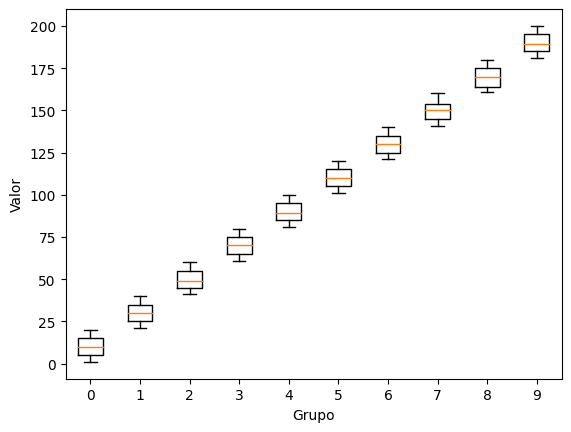

In [6]:

# Agrupando os valores por grupo
grouped_data = result.groupby('Bin')['Rank_dif'].apply(list)

# Criando o gráfico de boxplot
plt.boxplot(grouped_data)

# Definindo os rótulos dos eixos
plt.xlabel('Grupo')
plt.ylabel('Valor')

# Definindo os rótulos no eixo x
plt.xticks(range(1, len(grouped_data) + 1), grouped_data.index)

# Exibindo o gráfico
plt.show()

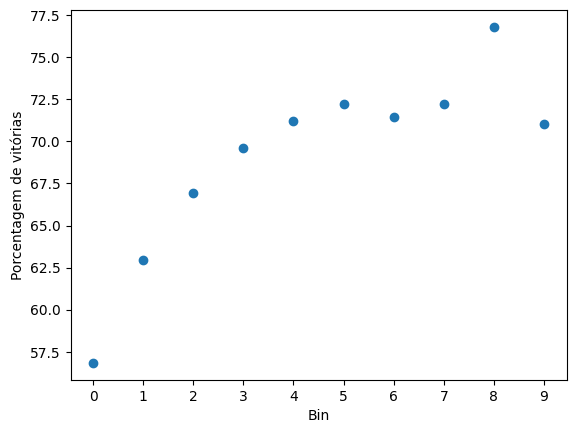

In [7]:
# Agrupando os dados por bin e calculando a porcentagem de vitória
grouped_data = result.groupby('Bin').apply(lambda x: (x['Rank_winner'] < x['Rank_loser']).mean() * 100)

# Criando o gráfico de pontos
plt.scatter(range(len(grouped_data)), grouped_data)

# Definindo os rótulos dos eixos
plt.xlabel('Bin')
plt.ylabel('Porcentagem de vitórias')

# Definindo os rótulos no eixo x
plt.xticks(range(len(grouped_data)), grouped_data.index)

# Exibindo o gráfico
plt.show()



In [8]:
# Calculando a porcentagem de vitórias por bin e court
grouped_data = result.groupby(['Court', 'Bin']).apply(lambda x: (x['Rank_winner'] < x['Rank_loser']).mean() * 100)
grouped_data = grouped_data.reset_index(name='Porcentagem')

# Definindo as cores para cada court
colors = px.colors.qualitative.Plotly[:len(result['Court'].unique())]

# Criando o gráfico de pontos interativo com legenda
fig = px.scatter(grouped_data, x='Bin', y='Porcentagem', color='Court', symbol='Court',
                 color_discrete_sequence=colors, title='Porcentagem de vitórias por Bin e Court')
fig.update_layout(legend_title='Court', legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1))

fig.update_layout(width=600, height=400, plot_bgcolor='white')


# Exibindo o gráfico
fig.show()

In [10]:
# Calculando a porcentagem de vitórias por bin e court
grouped_data = result.groupby(['Surface', 'Bin']).apply(lambda x: (x['Rank_winner'] < x['Rank_loser']).mean() * 100)
grouped_data = grouped_data.reset_index(name='Porcentagem')

# Definindo as cores para cada court
colors = px.colors.qualitative.Plotly[:len(result['Court'].unique())]

# Criando o gráfico de pontos interativo com legenda
fig = px.scatter(grouped_data, x='Bin', y='Porcentagem', color='Surface', symbol='Surface',
                 color_discrete_sequence=colors, title='Porcentagem de vitórias por Bin e Surface')
fig.update_layout(legend_title='Court', legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1))

fig.update_layout(width=600, height=400, plot_bgcolor='white')


# Exibindo o gráfico
fig.show()

In [11]:
# Calculando a porcentagem de vitórias por bin e court
grouped_data = result.groupby(['Round', 'Bin']).apply(lambda x: (x['Rank_winner'] < x['Rank_loser']).mean() * 100)
grouped_data = grouped_data.reset_index(name='Porcentagem')

# Definindo as cores para cada court
colors = px.colors.qualitative.Plotly[:len(result['Court'].unique())]

# Criando o gráfico de pontos interativo com legenda
fig = px.scatter(grouped_data, x='Bin', y='Porcentagem', color='Round', symbol='Round',
                 color_discrete_sequence=colors, title='Porcentagem de vitórias por Bin e Round')
fig.update_layout(legend_title='Court', legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1))

fig.update_layout(width=600, height=400, plot_bgcolor='white')


# Exibindo o gráfico
fig.show()

In [13]:
result.info()

result['Date'] = pd.to_datetime(result['Date'])

result = result.sort_values('Date')

result['num_vitorias'] = result.groupby('winner')['winner'].rolling(5).apply(lambda x: x.sum() - x[-1]).reset_index(level=0, drop=True)




<class 'pandas.core.frame.DataFrame'>
Index: 23878 entries, 1 to 24800
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Tournament   23878 non-null  object 
 1   Date         23878 non-null  object 
 2   Series       23878 non-null  object 
 3   Court        23878 non-null  object 
 4   Surface      23878 non-null  object 
 5   Round        23878 non-null  object 
 6   Best of      23878 non-null  int64  
 7   Player_1     23878 non-null  object 
 8   Player_2     23878 non-null  object 
 9   Winner       23878 non-null  object 
 10  Rank_1       23878 non-null  int64  
 11  Rank_2       23878 non-null  int64  
 12  Pts_1        23878 non-null  int64  
 13  Pts_2        23878 non-null  int64  
 14  Odd_1        23878 non-null  float64
 15  Odd_2        23878 non-null  float64
 16  score        23878 non-null  object 
 17  Rank_loser   23878 non-null  int64  
 18  Rank_winner  23878 non-null  int64  
 19  Rank_dif 

In [44]:
'''
This code receives a DataFrame named 'result' and performs the following operations:

Selects 11 columns from 'result' and assigns them to a new DataFrame named 'prep_treated_result'.
Converts the 'Date' column in 'prep_treated_result' to datetime format.
Defines a function named 'get_winner_loser_values' that assigns a value of 1 to the winner and -1 to the loser in each row of 'prep_treated_result', and applies this function to each row of the DataFrame, assigning the results to new columns named 'Player_1_value' and 'Player_2_value'.
Creates a new DataFrame named 'result_momentum' that selects 5 columns from 'prep_treated_result' and renames them to 'Date', 'Player_1', 'Player_2', 'Value_1', and 'Value_2', respectively.
Defines a function named 'stack_columns_and_running_sum' that concatenates the 'Date', 'Player_1', and 'Value_1' columns of 'result_momentum' with the 'Date', 'Player_2', and 'Value_2' columns of 'result_momentum' (renamed to 'Player' and 'Values', respectively), resulting in a new DataFrame named 'result_stacked'. This function also calculates the cumulative sum of the 'Values' column partitioned by 'Player' and ordered by 'Date', and assigns the result to a new column named 'Cumulative_Sum' in 'result_stacked'.
Applies the 'stack_columns_and_running_sum' function to 'result_momentum', assigning the result to 'result_momentum'.
Then, merges trated_result with momentum dataframe.
'''

prep_treated_result = result[['Date','Series','Court','Surface','Round','Best of','Player_1','Rank_1','Player_2','Rank_2','Rank_winner','Rank_loser']]

prep_treated_result['Date'] = pd.to_datetime(prep_treated_result['Date'])

#Funcao para definir valores aos vencedores e perdedores
def get_winner_loser_values(row):
    if row['Rank_winner'] == row['Rank_1']:
        return pd.Series({'Winner_Value': 1, 'Loser_Value': 0})
    else:
        return pd.Series({'Winner_Value': 0, 'Loser_Value': 1})

prep_treated_result[['Value_1', 'Value_2']] = prep_treated_result.apply(get_winner_loser_values, axis=1)


result_momentum = prep_treated_result[['Date','Player_1','Player_2','Value_1','Value_2']]

def stack_columns_and_running_sum(result):
    # Cria um novo DataFrame com as colunas empilhadas
    result_stacked = pd.concat([
        result[['Date', 'Player_1', 'Value_1']].rename(columns={'Player_1': 'Player', 'Value_1': 'Values'}),
        result[['Date', 'Player_2', 'Value_2']].rename(columns={'Player_2': 'Player', 'Value_2': 'Values'})
    ])

    # Calcula a soma cumulativa das últimas 5 vitórias para cada jogador, particionando por "Player" e ordenando por "Date"
    result_stacked = result_stacked.sort_values(['Player', 'Date'])
    result_stacked['Cumulative_Sum'] = result_stacked.groupby('Player')['Values'].rolling(window=5).sum().reset_index(drop=True)

    return result_stacked[['Date', 'Player', 'Values', 'Cumulative_Sum']]




result_momentum = stack_columns_and_running_sum(result_momentum)

treated_result = pd.merge(prep_treated_result, result_momentum, left_on=['Date', 'Player_1'], right_on=['Date', 'Player'])

treated_result = pd.merge(treated_result, result_momentum, left_on=['Date', 'Player_2'], right_on=['Date', 'Player'])




/var/folders/82/jg5v42nd1m352rr46mcjlyl80000gp/T/ipykernel_13869/995131792.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/82/jg5v42nd1m352rr46mcjlyl80000gp/T/ipykernel_13869/995131792.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/82/jg5v42nd1m352rr46mcjlyl80000gp/T/ipykernel_13869/995131792.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [45]:
treated_result

,Date,Series,Court,Surface,Round,Best of,Player_1,Rank_1,Player_2,Rank_2,Rank_winner,Rank_loser,Value_1,Value_2,Player_x,Values_x,Cumulative_Sum_x,Player_y,Values_y,Cumulative_Sum_y
0,2012-12-31,ATP250,Outdoor,Hard,1st Round,3,Benneteau J.,35,Nieminen J.,41,41,35,0,1,Benneteau J.,0,NaN,Nieminen J.,1,NaN
1,2013-01-01,ATP250,Outdoor,Hard,1st Round,3,Istomin D.,43,Klizan M.,30,43,30,1,0,Istomin D.,1,3.0,Klizan M.,0,3.0
2,2013-01-01,ATP250,Outdoor,Hard,1st Round,3,Baker B.,61,Dimitrov G.,48,48,61,0,1,Baker B.,0,NaN,Dimitrov G.,1,NaN
3,2013-01-02,ATP250,Outdoor,Hard,2nd Round,3,Mayer F.,28,Baghdatis M.,36,36,28,0,1,Mayer F.,0,1.0,Baghdatis M.,1,1.0
4,2013-01-03,ATP250,Outdoor,Hard,2nd Round,3,Goffin D.,46,Melzer J.,29,29,46,0,1,Goffin D.,0,1.0,Melzer J.,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24838,2022-10-25,ATP500,Indoor,Hard,1st Round,3,Ruud C.,3,Wawrinka S.,194,194,3,0,1,Ruud C.,0,2.0,Wawrinka S.,1,2.0
24839,2023-01-17,Grand Slam,Outdoor,Hard,1st Round,5,Hsu Y.,209,De Minaur A.,24,24,209,0,1,Hsu Y.,0,2.0,De Minaur A.,1,2.0
24840,2023-01-18,Grand Slam,Outdoor,Hard,2nd Round,5,Nishioka Y.,33,Svrcina D.,216,33,216,1,0,Nishioka Y.,1,2.0,Svrcina D.,0,2.0
24841,2023-01-19,Grand Slam,Outdoor,Hard,2nd Round,5,Holt B.,215,Bautista Agut R.,25,25,215,0,1,Holt B.,0,1.0,Bautista Agut R.,1,1.0


In [43]:


result_momentum[result_momentum['Player'] == 'Zverev M.'].sort_values('Date')

,Date,Player,Values,Cumulative_Sum
620,2013-03-07,Zverev M.,1,3.0
659,2013-03-10,Zverev M.,0,4.0
1331,2013-06-10,Zverev M.,1,4.0
1342,2013-06-12,Zverev M.,1,4.0
1348,2013-06-14,Zverev M.,0,2.0
...,...,...,...,...
17170,2019-07-01,Zverev M.,0,4.0
17325,2019-07-16,Zverev M.,1,1.0
17331,2019-07-17,Zverev M.,1,5.0
17334,2019-07-19,Zverev M.,0,4.0
